In [39]:
%matplotlib inline 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2


import pickle
df = pd.read_pickle("/home/maksim/Documents/Itten_files/new_abstract_2.pkl")

# Извлечение текстовых признаков

In [40]:
df.head()

,sale_date,Price,Author,Art,Owner,Sign,Technique,Material,Nazi,Framed,...,hasFollowers,hasAfter,mannerOf,circleOf,isUntitled,isNumbered,normalized_estimatefrom,normalized_estimateto,Auction,Paths
0,10.12.2018,8125,franz kline,UNTITLED,-,1,oil,canvas,0,0,...,0,0,0,0,1,0,6108.73,8144.98,Sotheby's,/home/maksim/Documents/Abstract_Images_cropped...
1,10.12.2018,40000,franz kline,UNTITLED,-,1,ink,paper,0,0,...,0,0,0,0,1,0,25453.05,35634.27,Sotheby's,/home/maksim/Documents/Abstract_Images_cropped...
2,07.03.2019,27500,mark rothko,UNTITLED (RECLINING NUDE),-,1,ink,paper,0,0,...,0,1,0,0,1,0,10000.00,15000.00,Sotheby's,/home/maksim/Documents/Abstract_Images_cropped...
3,16.07.2020,37500,cy twombly,UNTITLED,-,1,graphite,paper,0,0,...,0,1,0,0,1,0,20000.00,30000.00,Sotheby's,/home/maksim/Documents/Abstract_Images_cropped...
4,06.12.2019,37500,david smith,UNTITLED-NUDE,-,0,enamel,canvas,0,0,...,0,0,0,0,1,0,40000.00,60000.00,Sotheby's,/home/maksim/Documents/Abstract_Images_cropped...


In [41]:
df.columns

Index(['sale_date', 'Price', 'Author', 'Art', 'Owner', 'Sign', 'Technique',
       'Material', 'Nazi', 'Framed', 'Size', 'square_m', 'Currency',
       'EstimateFrom', 'EstimateTo', 'ExhibitedNum', 'ProvenanceNum',
       'LiteratureNum', 'CataloguingLength', 'Time', 'City', 'Description',
       'tried_url', 'Image', 'date_of_birth', 'date_of_death', 'century',
       'nationality', 'sex', 'style', 'repeat_sale', 'feature1', 'feature2',
       'number_of_day', 'day_of_week', 'month', 'year', 'deal_time_(utc)',
       'normalized_price', 'hasFollowers', 'hasAfter', 'mannerOf', 'circleOf',
       'isUntitled', 'isNumbered', 'normalized_estimatefrom',
       'normalized_estimateto', 'Auction', 'Paths'],
      dtype='object')

В столбце $\textbf{normalized_price}$ несколько неверных нулей. Заменим их на обычную цену.

In [42]:
df.loc[df['normalized_price'] < 100, 'normalized_price'] = df.loc[df['normalized_price'] < 100, 'Price']

In [43]:
X = df[['square_m', 'ExhibitedNum', 'ProvenanceNum',
       'LiteratureNum', 'date_of_birth', 'Sign']]
X

,square_m,ExhibitedNum,ProvenanceNum,LiteratureNum,date_of_birth,Sign
0,0.1144,1,2,1,1910,1
1,0.0590,11,8,0,1910,1
2,0.0516,0,3,0,1903,1
3,0.1104,1,6,0,1928,1
4,1.0357,1,2,0,1906,0
...,...,...,...,...,...,...
4229,3.3808,2,3,1,1926,1
4230,0.4294,0,0,0,1926,1
4231,0.4379,0,0,0,1926,1
4232,0.2176,0,0,0,1926,1


In [44]:
y = np.log(df['normalized_price'])

In [45]:
df['Material'].value_counts()

paper         2744
canvas         957
board          274
toile           83
panel           64
card            63
watercolor      32
linen           11
-                5
wood             1
Name: Material, dtype: int64

In [46]:
df['Technique'].value_counts()

\noil          826
oil            748
ink            659
gouache        644
lithograph     481
\nink          151
charcoal       143
pastel          85
graphite        76
aquatint        60
etching         57
acrylic         56
print           49
pencil          38
enamel          32
watercolor      28
tempera         17
woodcut         16
drypoint        15
watercolour     15
chalk           11
engraving        9
etcher           5
etchings         4
etchbook         3
etches           3
pigment          2
casein           1
Name: Technique, dtype: int64

Избавимся от $\textbf{\noil, \nink}$

In [47]:
df['Technique'].replace(['\noil', '\nink'], ['oil', 'ink'], inplace = True)

Как признаки оставим dummy переменные популярных стилей и материалов

In [48]:
dummy_tech = pd.get_dummies(df['Technique'])[['oil', 'ink','gouache', 'lithograph' ]]
dummy_mat = pd.get_dummies(df['Material'])[['canvas', 'paper']]
dummy_auc = pd.get_dummies(df['Auction'])

In [49]:
X

,square_m,ExhibitedNum,ProvenanceNum,LiteratureNum,date_of_birth,Sign
0,0.1144,1,2,1,1910,1
1,0.0590,11,8,0,1910,1
2,0.0516,0,3,0,1903,1
3,0.1104,1,6,0,1928,1
4,1.0357,1,2,0,1906,0
...,...,...,...,...,...,...
4229,3.3808,2,3,1,1926,1
4230,0.4294,0,0,0,1926,1
4231,0.4379,0,0,0,1926,1
4232,0.2176,0,0,0,1926,1


In [50]:
from sklearn import preprocessing
names = ['square_m', 'ExhibitedNum','ProvenanceNum', 'LiteratureNum','date_of_birth']
scaler = preprocessing.StandardScaler()

scaled_X = scaler.fit_transform(X[names])
scaled_X = pd.DataFrame(scaled_X, columns=names)

In [51]:
X_text = scaled_X.join(dummy_tech).join(dummy_mat).join(dummy_auc).join(X['Sign'])

In [52]:
X_text

,square_m,ExhibitedNum,ProvenanceNum,LiteratureNum,date_of_birth,oil,ink,gouache,lithograph,canvas,paper,Christie's,Sotheby's,Sign
0,-0.496600,-0.129774,-0.407388,0.009593,0.474437,1,0,0,0,1,0,0,1,1
1,-0.545896,3.756095,2.284933,-0.511134,0.474437,0,1,0,0,0,1,0,1,1
2,-0.552481,-0.518361,0.041332,-0.511134,0.039437,0,1,0,0,0,1,0,1,1
3,-0.500159,-0.129774,1.387493,-0.511134,1.593006,0,0,0,0,0,1,0,1,1
4,0.323198,-0.129774,-0.407388,-0.511134,0.225866,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,2.409932,0.258813,0.041332,0.009593,1.468721,1,0,0,0,1,0,1,0,1
4230,-0.216304,-0.518361,-1.304828,-0.511134,1.468721,0,0,0,1,0,1,1,0,1
4231,-0.208741,-0.518361,-1.304828,-0.511134,1.468721,0,0,0,1,0,1,1,0,1
4232,-0.404770,-0.518361,-1.304828,-0.511134,1.468721,0,0,0,1,0,1,1,0,1


In [40]:
np.any(pd.isna(X_text))

False

# Извлечение визуальных признаков

## Круги Иттена

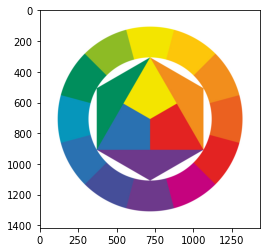

In [10]:
path = "/home/maksim/Documents/Itten_files/itten.jpg"
image = cv2.imread(path)[:,:,::-1]
plt.imshow(image)
plt.imsave('/home/maksim/Documents/Itten_files/itten_diag.jpg', image)
plt.show()

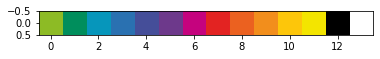

In [28]:
itten_colors = [
    image[300][510], image[400][300], image[700][250], image[1000][250], image[1200][500], image[1200][750],
image[1100][1000], image[1000][1100], image[750][1200], image[500][1200], image[300][900], image[300][700], [0,0,0],[255,255,255]]

itten_colors_lab = cv2.cvtColor(np.array([itten_colors], 'float32') / 255, cv2.COLOR_RGB2LAB).reshape(-1,3)

plt.imshow([itten_colors])
plt.show()
plt.imsave('/home/maksim/Documents/Itten_files/itten_colors.jpg', [itten_colors])


In [31]:
from sklearn.metrics.pairwise import euclidean_distances


def get_image(i):
    return cv2.imread(df.Paths[i])
def get_pixel(i, j, num):
    return np.array([[get_image(num)[i][j]]])



def get_itten_colors_and_mean_error(image_index):
    lab_img = cv2.cvtColor(np.array(get_image(image_index), 'float32')/255, cv2.COLOR_BGR2LAB)
    euclid_dist = euclidean_distances(lab_img.reshape(-1,3), itten_colors_lab)
    closest_colors = np.argmin(euclid_dist, axis=1)
    indexes_closest_colors, count_closest_colors = np.unique(closest_colors, return_counts=True)
    freq_closest_colors = count_closest_colors / count_closest_colors.sum()
    
    index_freq_colors = list(zip(indexes_closest_colors, freq_closest_colors))
    for i in range(12):
        if i not  in indexes_closest_colors:
            index_freq_colors.insert(i, (i,0))
    
    errors = np.array([0 for i in range(14)])
    
    for i in range(len(euclid_dist)):
        dist_from_actual_to_closest_in_lab = euclid_dist[i][closest_colors[i]]
        errors[closest_colors[i]] += dist_from_actual_to_closest_in_lab
    
    j = 0
    for i in range(14):
        if errors[i] != 0:
            errors[i] = errors[i] / count_closest_colors[j]
            j += 1
            
    return np.append(np.array(index_freq_colors)[:,1], np.mean(errors))

    

def get_freq(index):
    l = get_image_colors(index)
    return np.array([l[0], l[1]])

In [32]:
get_itten_colors_and_mean_error(3)

array([0.00000000e+00, 1.56982351e-05, 2.61902626e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.12130250e-06, 6.72781503e-06, 0.00000000e+00, 0.00000000e+00,
       2.47695723e-03, 9.71309233e-01, 1.75000000e+01])

In [33]:
%%time
size = np.shape(df)[0]
colors_freq_and_error = [get_itten_colors_and_mean_error(x) for x in range(size)]

CPU times: user 2h 34min 34s, sys: 3min 10s, total: 2h 37min 45s
Wall time: 4h 1min 12s


In [34]:
X_itten_colors = pd.DataFrame(
    colors_freq_and_error, 
    columns=["салатовый","зеленый", "бирюзовый","синий","темно-синий",
             "фиолетовый", "розовый","красный","ярко_оранжевый","оранжевый","ярко_желтый","желтый","черный","белый","error"])
X_itten_colors

,салатовый,зеленый,бирюзовый,синий,темно-синий,фиолетовый,розовый,красный,ярко_оранжевый,оранжевый,ярко_желтый,желтый,черный,белый,error
0,0.056880,0.118093,0.000647,0.000000,0.000000,0.000000,0.000001,0.001254,0.015527,0.164386,0.022073,0.000000,0.588752,0.032386,25.357143
1,0.000000,0.001844,0.004468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,0.001224,0.000000,0.000000,0.276304,0.716154,13.214286
2,0.000000,0.038162,0.062094,0.000231,0.000000,0.000000,0.000000,0.000000,0.000006,0.000102,0.000000,0.000000,0.527451,0.371953,19.214286
3,0.000000,0.000016,0.026190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000007,0.000000,0.000000,0.002477,0.971309,17.500000
4,0.000000,0.000009,0.005829,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139985,0.854175,11.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,0.145091,0.120866,0.117984,0.046947,0.024518,0.000334,0.000041,0.000046,0.027312,0.058005,0.008202,0.007316,0.172430,0.270908,26.571429
4230,0.000000,0.155795,0.034015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266592,0.543598,6.642857
4231,0.000000,0.004297,0.042944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000399,0.000000,0.000000,0.521267,0.431093,12.428571
4232,0.040038,0.086644,0.058074,0.016502,0.006818,0.000000,0.000000,0.000000,0.000000,0.014243,0.018666,0.000000,0.203246,0.555769,18.357143


In [57]:
import pickle

new_df = df[['Art','Author', 'Paths']].join(y).join(X_text).join(X_itten_colors)
new_df.to_pickle("/home/maksim/Documents/Itten_files/new_abstract_3.pkl")

In [1]:
import pickle
import pandas as pd
import numpy as np
df = pd.read_pickle("/home/maksim/Documents/Itten_files/new_abstract_3.pkl")

In [2]:
df

,Art,Author,Paths,normalized_price,square_m,ExhibitedNum,ProvenanceNum,LiteratureNum,date_of_birth,oil,...,фиолетовый,розовый,красный,ярко_оранжевый,оранжевый,ярко_желтый,желтый,черный,белый,error
0,UNTITLED,franz kline,/home/maksim/Documents/Abstract_Images_cropped...,9.005157,-0.496600,-0.129774,-0.407388,0.009593,0.474437,1,...,0.000000,0.000001,0.001254,0.015527,0.164386,0.022073,0.000000,0.588752,0.032386,25.357143
1,UNTITLED,franz kline,/home/maksim/Documents/Abstract_Images_cropped...,10.481063,-0.545896,3.756095,2.284933,-0.511134,0.474437,0,...,0.000000,0.000000,0.000000,0.000005,0.001224,0.000000,0.000000,0.276304,0.716154,13.214286
2,UNTITLED (RECLINING NUDE),mark rothko,/home/maksim/Documents/Abstract_Images_cropped...,9.615805,-0.552481,-0.518361,0.041332,-0.511134,0.039437,0,...,0.000000,0.000000,0.000000,0.000006,0.000102,0.000000,0.000000,0.527451,0.371953,19.214286
3,UNTITLED,cy twombly,/home/maksim/Documents/Abstract_Images_cropped...,10.308953,-0.500159,-0.129774,1.387493,-0.511134,1.593006,0,...,0.000000,0.000000,0.000000,0.000001,0.000007,0.000000,0.000000,0.002477,0.971309,17.500000
4,UNTITLED-NUDE,david smith,/home/maksim/Documents/Abstract_Images_cropped...,11.002100,0.323198,-0.129774,-0.407388,-0.511134,0.225866,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139985,0.854175,11.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,Xavier \n,Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,14.195178,2.409932,0.258813,0.041332,0.009593,1.468721,1,...,0.000334,0.000041,0.000046,0.027312,0.058005,0.008202,0.007316,0.172430,0.270908,26.571429
4230,"Composition in Black and Green, from Trees \n",Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,7.509757,-0.216304,-0.518361,-1.304828,-0.511134,1.468721,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266592,0.543598,6.642857
4231,Joan Mitchell (1925-1992),Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,8.810248,-0.208741,-0.518361,-1.304828,-0.511134,1.468721,0,...,0.000000,0.000000,0.000000,0.000000,0.000399,0.000000,0.000000,0.521267,0.431093,12.428571
4232,"Nathan Kernan, Poems, Mount Kisco, New York, T...",Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,7.049810,-0.404770,-0.518361,-1.304828,-0.511134,1.468721,0,...,0.000000,0.000000,0.000000,0.000000,0.014243,0.018666,0.000000,0.203246,0.555769,18.357143


## Canny edge detection

1. Apply Gaussian filter to smooth the grayscaled image in order to remove the noise
* The equation for a Gaussian filter kernel of size (2k+1)×(2k+1) is given by:
$$ H_{i,j} = \frac{1}{2 \pi \sigma^2}
 \exp\biggl(\,  - \frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2} \biggr)$$
* It is important to understand that the selection of the size of the Gaussian kernel will affect the performance of the detector. The larger the size is, the lower the detector's sensitivity to noise. Additionally, the localization error to detect the edge will slightly increase with the increase of the Gaussian filter kernel size.

2. Find the intensity gradients of the image A

$$ G_x =  \begin{bmatrix}
    1 & 0 & -1 \\
    2 & 0 & -2 \\
    1 & 0 & -1
\end{bmatrix} * A \; \; \; \; \;
G_y =  \begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1
\end{bmatrix} * A
 $$
 
 $$ G = \sqrt{G_{x}^2 + G_{y}^2}$$
*  gradient's direction:
$$ \theta = arctg \biggl(\frac{G_y}{G_x} \biggr)$$

3. Non-maximum Suppression
* Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions.
* If the edge strength of the current pixel is the largest compared to the other pixels in the mask with the same direction, the value will be preserved. Otherwise, the value will be suppressed.
4. Apply double threshold to determine potential edges
5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

In [27]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def get_lines_var(i):
    edges = cv2.Canny(cv2.imread(df.Paths[i]),100,200)
    return (edges != 0).sum() / edges.size

def plot_edge_image(i):
    img = cv2.imread(df.Paths[i])[:,:,::-1]
    edges = cv2.Canny(img,100,200)
    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    print("lines variance = {}".format(np.round(np.var(edges.reshape(1,-1)[0]/255),3)))


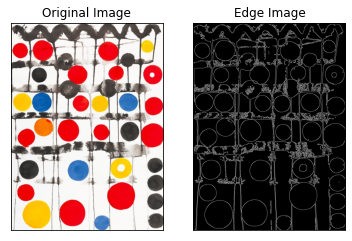

lines variance = 0.067


In [28]:
plot_edge_image(35)

In [29]:
%%time
var = np.array([get_lines_var(i) for i in np.arange(df.shape[0])])

CPU times: user 3min 4s, sys: 12.4 s, total: 3min 17s
Wall time: 59.7 s


In [30]:
contrst_triad, classic_triad, analog_triad, quad, rectangle, comp = (set() for _ in range(6))


for i in range(12):
    tup = (i, (((i + 6) % 12) + 1) % 12, (((i + 6) % 12) - 1)  % 12) 
    contrst_triad.add(tuple(sorted(tup)))
    
    tup = (i, (((i + 6) % 12) + 2) % 12, (((i + 6) % 12) - 2)  % 12) 
    classic_triad.add(tuple(sorted(tup)))
    
    tup = (i, (i + 1) % 12, (i - 1) % 12) 
    analog_triad.add(tuple(sorted(tup)))
    
    tup = (i, (i+3) % 12, (i+6) % 12, (i+9) %12) 
    quad.add(tuple(sorted(tup)))
    
    tup = (i, (i+6) % 12, (i+4) % 12, (i-2) %12) 
    rectangle.add(tuple(sorted(tup)))
    
    tup = (i, (i + 6) % 12)
    comp.add(tuple(sorted(tup)))

In [31]:
quad

{(0, 3, 6, 9), (1, 4, 7, 10), (2, 5, 8, 11)}

In [51]:
colors = df[['салатовый', 'зеленый', 'бирюзовый', 'синий',
       'темно-синий', 'фиолетовый', 'розовый', 'красный', 'ярко_оранжевый',
       'оранжевый', 'ярко_желтый', 'желтый']]

comp_colors = np.array([colors.values[i].argsort()[-3:][::-1] for i in range(colors.shape[0])])
triple_colors = np.array([colors.values[i].argsort()[-4:][::-1] for i in range(colors.shape[0])])
quad_colors = np.array([colors.values[i].argsort()[-5:][::-1] for i in range(colors.shape[0])])


In [52]:
def get_itten_combo(all_colors, all_paterns, n):
    X_temp = []
    for colors in all_colors:
        append = 1
        for pattern in all_paterns:
            if len(set(colors).intersection(pattern)) == n:
                append = 0
                X_temp.append(1)
                break
        if append:
            X_temp.append(0)
    return X_temp
        
    


X_contrst_triad = get_itten_combo(triple_colors, contrst_triad, 3)
X_classic_triad = get_itten_combo(triple_colors, classic_triad, 3)
X_analog_triad = get_itten_combo(triple_colors, analog_triad, 3)

X_quad = get_itten_combo(quad_colors, quad, 4)
X_rectangle = get_itten_combo(quad_colors, rectangle, 4)
X_comp = get_itten_combo(comp_colors, comp, 2)

In [59]:
path = "/home/maksim/Documents/Itten_files/itten.jpg"
color_wheel = cv2.imread(path)[:,:,::-1]

itten_colors = [
    color_wheel[300][510], color_wheel[400][300], color_wheel[700][250], color_wheel[1000][250], color_wheel[1200][500], color_wheel[1200][750],
color_wheel[1100][1000], color_wheel[1000][1100], color_wheel[750][1200], color_wheel[500][1200], color_wheel[300][900], color_wheel[300][700], [0,0,0],[255,255,255]]

itten_colors_lab = cv2.cvtColor(np.array([itten_colors], 'float32') / 255, cv2.COLOR_RGB2LAB).reshape(-1,3)



Контрастная триада, найдено 345 вхождений


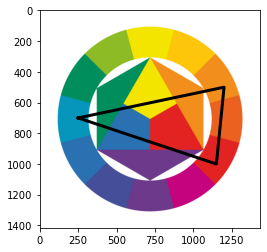

Классическая триада , найдено 105 вхождений


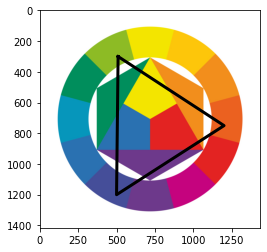

Аналоговая триада, найдено 1905 вхождений


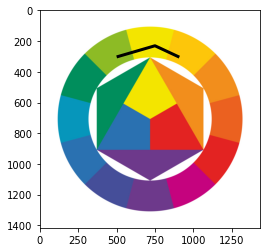

Квадрат, найдено 22 вхождений


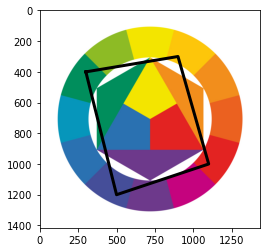

Прямоугольник , найдено 58 вхождений


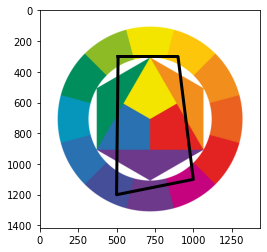

Дополняющие , найдено 802 вхождений


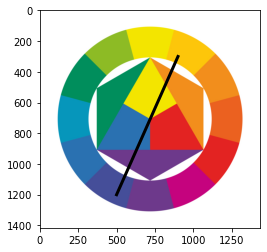

In [54]:
d = dict({0: (300,510), 
         1: (400,300), 
         2: (700, 250),
         3: (1000,250), 
         4: (1200,500), 
         5: (1200, 750),
         6: (1100,1000), 
         7: (1000,1100), 
         8: (750, 1200),
         9: (500,1200), 
         10: (300,900), 
         11: (250, 750),
         })


for colors in contrst_triad:
    print("Контрастная триада, найдено {} вхождений".format(np.sum(X_contrst_triad)))
    y = [d[colors[0]][0], d[colors[1]][0], d[colors[2]][0], d[colors[0]][0]]
    x = [d[colors[0]][1], d[colors[1]][1] + 50, d[colors[2]][1], d[colors[0]][1]]
    plt.plot(x, y, color="black", linewidth=3)
    plt.imshow(color_wheel)
    plt.show()
    break
    
for colors in classic_triad:
    print("Классическая триада , найдено {} вхождений".format(np.sum(X_classic_triad)))

    y = [d[colors[0]][0], d[colors[1]][0], d[colors[2]][0], d[colors[0]][0]]
    x = [d[colors[0]][1], d[colors[1]][1], d[colors[2]][1], d[colors[0]][1]]
    plt.plot(x, y, color="black", linewidth=3)
    plt.imshow(color_wheel)
    plt.show()
    break

for colors in analog_triad:
    print("Аналоговая триада, найдено {} вхождений".format(np.sum(X_analog_triad)))
    y = [ d[colors[1]][0], d[colors[2]][0] - 20, d[colors[0]][0]]
    x = [ d[colors[1]][1], d[colors[2]][1], d[colors[0]][1]]
    plt.plot(x, y, color="black", linewidth=3)
    plt.imshow(color_wheel)
    plt.show()
    break


for colors in quad:
    print("Квадрат, найдено {} вхождений".format(np.sum(X_quad)))

    y = [d[colors[0]][0], d[colors[1]][0], d[colors[2]][0], d[colors[3]][0],d[colors[0]][0]]
    x = [d[colors[0]][1], d[colors[1]][1], d[colors[2]][1], d[colors[3]][1],d[colors[0]][1]]
    plt.plot(x, y, color="black", linewidth=3)
    plt.imshow(color_wheel)
    plt.show()
    break

for colors in rectangle:
    print("Прямоугольник , найдено {} вхождений".format(np.sum(X_rectangle)))

    y = [d[colors[0]][0], d[colors[1]][0], d[colors[2]][0], d[colors[3]][0],d[colors[0]][0]]
    x = [d[colors[0]][1], d[colors[1]][1], d[colors[2]][1], d[colors[3]][1],d[colors[0]][1]]
    plt.plot(x, y, color="black", linewidth=3)
    plt.imshow(color_wheel)
    plt.show()
    break
    
for colors in comp:
    print("Дополняющие , найдено {} вхождений".format(np.sum(X_comp)))

    y = [d[colors[0]][0], d[colors[1]][0]]
    x = [d[colors[0]][1], d[colors[1]][1]]
    plt.plot(x, y, color="black", linewidth=3)
    plt.imshow(color_wheel)
    plt.show()
    break

In [55]:
itten_data = pd.DataFrame(np.column_stack([X_contrst_triad, X_classic_triad, X_rectangle, X_analog_triad, X_quad, X_comp]), 
                               columns=['X_contrst_triad', 'X_classic_triad', 'X_rectangle', 'X_analog_triad', 'X_quad', 'X_comp'])

In [60]:
from sklearn.metrics.pairwisecountport euclidean_distances

def get_image(i):
    return cv2.imread(df.Paths[i])
def get_pixel(i, j, num):
    return np.array([[get_image(num)[i][j]]])


def get_image_colors(image_index):
    lab_img = cv2.cvtColor(np.array(get_image(image_index), 'float32')/255, cv2.COLOR_BGR2LAB)
    
    closest_colors = np.argmin(euclidean_distances(lab_img.reshape(-1,3), itten_colors_lab),axis=1)
    v, c = np.unique(closest_colors, return_counts=True)
    c = c / c.sum()
    return v, c, closest_colors, np.shape(lab_img)

def plot_itten(image_index):
    im_data = get_image_colors(image_index)
    im = im_data[2]
    im_shape = (im_data[3][0],im_data[3][1])
    f = lambda x: np.array(itten_colors)[x]
    itten_im = f(im.reshape(im_shape))
    cur_im = get_image(image_index)[:,:,::-1]
    fig, axarr = plt.subplots(1,2)
    axarr[0].set_axis_off()
    axarr[1].set_axis_off()
    axarr[0].imshow(itten_im)
    axarr[1].imshow(cur_im)
    axarr[0].text(0, -100, 'Itten')
    axarr[1].text(0, -100, df['Art'][image_index])
    plt.show()
    

def plot_freq(image_index):
    image = get_image(image_index)    
    colors_info = get_image_colors(image_index)
    colors_indexes, colors_freq = colors_info[0], colors_info[1]
    
    colors = np.array([])
    for j, i in enumerate(colors_indexes):
        itten_pixel = np.array([[itten_colors[int(i)]]], 'float32')
        width = int(10*colors_freq[int(j)]) + 1
        height = 1
        resized = cv2.resize(itten_pixel, (width, height), interpolation = cv2.INTER_AREA)
        if colors_freq[int(j)] > 0.05:
            colors = np.append(colors, resized)
        
    colors = np.reshape(colors, (len(colors) // 3,-1))
    plt.imshow(np.array([colors]).astype(np.uint8))
    plt.show()
    
def plot_edge_image(i):
    img = cv2.imread(df.Paths[i])[:,:,::-1]
    edges = cv2.Canny(img,100,200)
    plt.subplot(121),plt.imshow(img,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    print("Дисперсия линий =",np.round(np.var(edges.reshape(1,-1)[0]/255),3))
    
def plot_itten_info(i):
#     plot_edge_image(i)
    plot_itten(i)
    plot_freq(i)

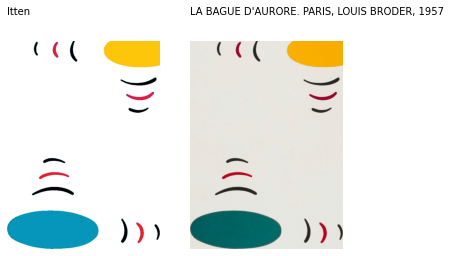

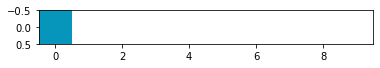

Средняя ошибка = 20.714285714285715


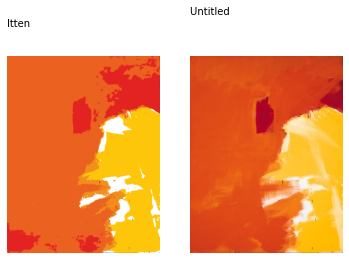

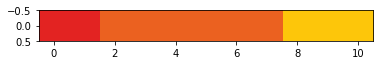

Средняя ошибка = 20.928571428571427


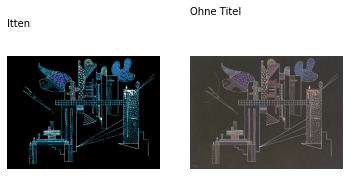

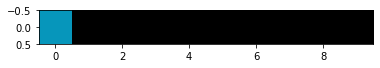

Средняя ошибка = 20.785714285714285


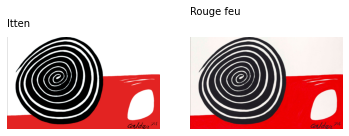

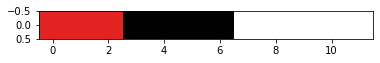

Средняя ошибка = 13.428571428571429


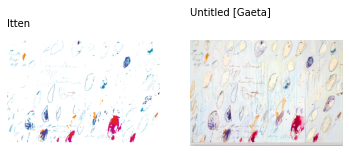

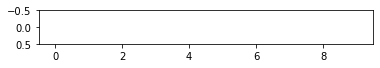

Средняя ошибка = 25.071428571428573


In [61]:
for i in np.random.choice(4000, 5):
    plot_itten_info(i)
    print("Средняя ошибка =", df.error[i])

In [62]:
import pickle

full_df = df.join(pd.DataFrame(var, columns=["lines_variance"])).join(itten_data)
full_df.to_pickle("/home/maksim/Documents/Itten_files/new_abstract_4.pkl")

## Color complexity measure

In [615]:
X = pd.read_pickle("/home/maksim/Documents/Itten_files/new_abstract_4.pkl")

In [616]:
N = 3


def get_image(i):
    return cv2.imread(X.Paths[i])

def get_pixel(i, j, num):
    return get_image(num)[i][j]


def get_lab_image(num_image):
    return cv2.cvtColor(np.array(get_image(num_image), 'float32')/255, cv2.COLOR_BGR2LAB)

def plot_window(num_image, i, j):
    cur_window = get_image(num_image)[i-N:i+N,j-N:j+N, :: -1]
    plt.imshow(cur_window)
    plt.show()
    
def plot_image(num_image):
    plt.imshow(get_image(num_image)[:,:,::-1])
    plt.show()

In [617]:
def gauss(x, a, b, c):
    return a*np.exp(-(x - b)**2 / (2*(c**2)))


def color_diff_measure(pix_1, pix_2, gamma):
    euclid_dist = np.linalg.norm(pix_1 - pix_2)
    return 1 - np.exp(-euclid_dist/gamma)
    
def CCM_pixel(i, j, cur_image):
    c_average = np.array([0.,0.,0.])
    for x in range(i - N, i + N):
        for y in range(j - N, j + N):
            c_average += cur_image[x][y]
    c_average = c_average/ ((2*N) ** 2)
    
    psi = 0
    for x in range(i - N, i + N):
        for y in range(j - N, j + N):
            psi += gauss(color_diff_measure(cur_image[x][y], c_average, 20), 10, 3.7, 1)
    return np.round(psi,4)

def CCM_image(num_image):
    cur_image = get_lab_image(num_image)
    length, width, _ = np.shape(cur_image)
    average_CCM = 0
    total = 0
    for x in range(N, length - N, 2*N):
        for y in range(N, width - N, 2*N):
            total += 1
            average_CCM += CCM_pixel(x, y, cur_image)
    return average_CCM/(total)

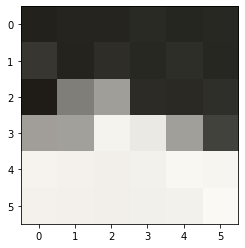

5.6578


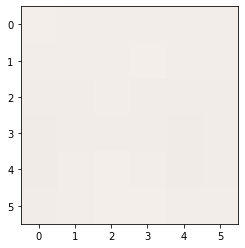

0.4018


In [626]:
cur_img = get_lab_image(143)

plot_window(143, 55, 102)
print(CCM_pixel(55, 102, cur_img))

plot_window(143, 70, 70)
print(CCM_pixel(70, 70, cur_img))


In [627]:
%%time
ccm_paintings = []
for i in range(np.shape(X)[0]):
    ccm_paintings.append(CCM_image(i))

CPU times: user 9h 29min 13s, sys: 20.2 s, total: 9h 29min 33s
Wall time: 19h 18min 21s


In [636]:
ccm_paintings

[0.978567561290318,
 0.6675712005483734,
 1.3389061752680764,
 0.5496713611969417,
 0.9061384308390057,
 1.0203339393939408,
 0.6416617826725438,
 1.4930514538626796,
 0.8900495203209473,
 1.279413251748256,
 0.8806697241922775,
 1.098556385842159,
 1.250512512273441,
 0.960940916944343,
 0.8120459539223397,
 1.6690031511900805,
 1.515038638876591,
 0.9979031095266283,
 0.8412137544273804,
 0.7000854668247848,
 0.7282647869939105,
 1.8185913703703755,
 1.2099104861111283,
 1.1467914527333318,
 0.7867995529961251,
 0.997671002155181,
 0.7727308486499224,
 1.0593030318500243,
 0.7669184125767675,
 0.689984561265259,
 0.6713895976722041,
 0.9424183329929855,
 0.9488150946275821,
 0.5917168948628284,
 0.7710140606864525,
 1.2416453152963922,
 0.6334279178337999,
 1.3047916431769238,
 0.813191690457385,
 1.2142873417721538,
 0.7275383836937078,
 0.7644871537329672,
 1.0155238148354855,
 1.1560529391164225,
 1.0182717074336873,
 0.9348051322369441,
 0.916209115095431,
 1.0394428010345855,
 1

In [637]:
df_ccm = X.join(pd.DataFrame(ccm_paintings, columns=['ccm']))

In [638]:
df_ccm.to_pickle("/home/maksim/Documents/new_abstract_5.pkl")

## Points of interest

In [3]:
%matplotlib inline 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pickle



df = pd.read_pickle("/home/maksim/Documents/new_abstract_5.pkl")

In [127]:
n = 4
r = 6

def get_image(i):
    return cv2.imread(df.Paths[i])[:,:,::-1]


def get_gray_level(pixel):
    return 0.299*pixel[0] + 0.587 *pixel[1] + 0.114*pixel[2]


def circle(n,i,j):
    if n == 1:
        return [(i+1,j),(i+1,j+1),(i+1,j-1), (i,j+1), (i,j-1), (i-1,j),(i-1,j+1),(i-1,j-1)]
    cur = circle(n-1, i, j)
    new = []
    for x in cur:
        if x[0] < i:
            new.append((x[0]-1,x[1]))
        else:
            new.append((x[0]+1,x[1]))
        if x[1] < j:
            new.append((x[0],x[1]-1))
        else:
            new.append((x[0],x[1]+1))

    return list(set([x for x in new if x not in cur]))



def E(i,j, image):
    E = 0
    circle_1 = circle(r, i, j)
    circle_2 = circle(r + 1, i, j)
    
    for x in circle_1:
        for y in circle_2:
            if (x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2 == 1:
                E += np.abs(get_gray_level(image[x[0]][x[1]]) - get_gray_level(image[y[0]][y[1]]))
    return E

def T(i, j, k, image):
    T = 0
    for pixel in circle(r, i, j):
        x = pixel[0]
        y = pixel[1]
        T += np.abs((x - i)*np.sin(np.pi*k/n) - (y - j)*np.cos(np.pi*k/n))*get_gray_level(image[x][y])
    return T

def DST_pixel(i,j, image):
    sum_T = 0
    sum_T_2 = 0
    for k in range(n):
        T_s = T(i, j, k, image)
        sum_T += T_s
        sum_T_2 += T_s ** 2
        
    return E(i,j, image) * (1 - np.sqrt(sum_T_2/n - (sum_T/n) ** 2))

def DST_image(image):
    my_DST = np.array([])
    length, width, _ = np.shape(image)
    for i in range(r, length - r - 1, 3*r):
        for j in range(r, width - r - 1, 3*r):
            my_DST = np.append(DST_pixel(i,j, image), my_DST)
    return my_DST

In [161]:
def get_percent_points_of_interest(i):
    im = get_image(i)[:,:,::-1]
    my_DST = DST_image(im)
    num_points = 0
    all_pixels = 0
    for dst in my_DST:
        all_pixels += 1
        if dst > 1.5*np.mean(my_DST) + np.std(my_DST):
            num_points += 1
    return 100*num_points/all_pixels

In [162]:
%%time
points = []
for i in range(df.shape[0]):
    points.append(get_percent_points_of_interest(i))

CPU times: user 7h 58min 50s, sys: 39 s, total: 7h 59min 29s
Wall time: 10h 25s


In [166]:
df_points = df.join(pd.DataFrame(points, columns = ['points_of_interest']))

In [167]:
df_points.to_pickle("/home/maksim/Documents/new_abstract_6.pkl")

## Metrics from HSV space

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2


import pickle

df = pd.read_pickle("/home/maksim/Documents/new_abstract_6.pkl")
df

,Art,Author,Paths,normalized_price,square_m,ExhibitedNum,ProvenanceNum,LiteratureNum,date_of_birth,oil,...,error,lines_variance,X_contrst_triad,X_classic_triad,X_rectangle,X_analog_triad,X_quad,X_comp,ccm,points_of_interest
0,UNTITLED,franz kline,/home/maksim/Documents/Abstract_Images_cropped...,9.005157,-0.496600,-0.129774,-0.407388,0.009593,0.474437,1,...,0.133028,0.095431,0,0,0,0,0,0,0.978568,27.747253
1,UNTITLED,franz kline,/home/maksim/Documents/Abstract_Images_cropped...,10.481063,-0.545896,3.756095,2.284933,-0.511134,0.474437,0,...,-0.038595,0.017660,0,1,0,0,0,0,0.667571,0.000000
2,UNTITLED (RECLINING NUDE),mark rothko,/home/maksim/Documents/Abstract_Images_cropped...,9.615805,-0.552481,-0.518361,0.041332,-0.511134,0.039437,0,...,-0.019526,0.166352,0,0,0,0,0,0,1.338906,41.827586
3,UNTITLED,cy twombly,/home/maksim/Documents/Abstract_Images_cropped...,10.308953,-0.500159,-0.129774,1.387493,-0.511134,1.593006,0,...,-0.006813,0.040357,0,0,0,0,0,0,0.549671,0.000000
4,UNTITLED-NUDE,david smith,/home/maksim/Documents/Abstract_Images_cropped...,11.002100,0.323198,-0.129774,-0.407388,-0.511134,0.225866,0,...,-0.110332,0.031795,0,0,0,0,0,0,0.906138,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,Xavier \n,Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,14.195178,2.409932,0.258813,0.041332,0.009593,1.468721,1,...,0.044038,0.154257,0,0,0,1,0,0,1.555700,39.387464
4230,"Composition in Black and Green, from Trees \n",Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,7.509757,-0.216304,-0.518361,-1.304828,-0.511134,1.468721,0,...,-0.178437,0.131192,0,0,0,0,0,0,1.416613,32.051282
4231,Joan Mitchell (1925-1992),Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,8.810248,-0.208741,-0.518361,-1.304828,-0.511134,1.468721,0,...,-0.062205,0.097922,0,0,0,0,0,0,1.087792,42.013889
4232,"Nathan Kernan, Poems, Mount Kisco, New York, T...",Joan Mitchell,/home/maksim/Documents/Abstract_Images_cropped...,7.049810,-0.404770,-0.518361,-1.304828,-0.511134,1.468721,0,...,0.034958,0.139372,0,0,0,0,0,0,1.556164,38.750000


In [3]:
def hsv_image(i):
    im = cv2.cvtColor(cv2.imread(df['Paths'][i]), cv2.COLOR_BGR2HSV)
    return np.mean(im[:,:,0]), np.mean(im[:,:,1]), np.mean(im[:,:,2])

In [4]:
mean_h = []
mean_s = []
mean_v = []

for i in range(df.shape[0]):
    h,s,v = hsv_image(i)
    mean_h.append(h)
    mean_s.append(s)
    mean_v.append(v)

In [5]:
df['mean_h'] = mean_h
df['mean_s'] = mean_s
df['mean_v'] = mean_v

In [ ]:
df.to_pickle("/home/maksim/Documents/new_abstract_7.pkl")